In [56]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
from torch import Tensor
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
from torchsummary import summary
import torchvision as tv
from torch.utils.data import DataLoader as DataLoader
from torchvision import datasets
from time import time

In [24]:
patch_size = 16 # 16 pixels
# patches = rearrange(x, 'b c (h s1) (w s2) -> b (h w) (s1 s2 c)', s1=patch_size, s2=patch_size)
# patches.shape
x = torch.randn((1,3,64,64))

In [25]:
class PatchEmbedding(nn.Module):
  def __init__(self,in_channels=3,patch_size=16,embed_size=768,img_size=64): # embed size is base on patch_size * patch_size * in_channels
    self.patch_size = patch_size
    super().__init__()
    self.linear_projection = nn.Sequential( ### Linear Projection image
            # break-down the image in s1 x s2 patches and flat them
            Rearrange('b c (h s1) (w s2) -> b (h w) (s1 s2 c)', s1=patch_size, s2=patch_size),
            nn.Linear(patch_size * patch_size * in_channels, embed_size)
    )
    self.conv_projection = nn.Sequential( # Projection with Convolution 2d
        nn.Conv2d(in_channels=in_channels,out_channels=embed_size,kernel_size=patch_size,stride=patch_size),
        Rearrange('b e (h) (w) -> b (h w) e'),

    )

    self.cls_token = nn.Parameter(torch.randn(1,1,embed_size))
     # The position embedding is just a tensor of shape N_PATCHES + 1 (token), EMBED_SIZE that is added to the projected patches
    self.positions = nn.Parameter(torch.randn((img_size//patch_size)**2 + 1, embed_size))
   

  def forward(self,x,projection='conv2d'): # both conv and linear projection are same but i code both of them for better understandig of my self
    b , _ , _ , _ = x.shape # b is batch time or number of batch
    
    if projection == 'conv2d':
      x = self.conv_projection(x) 
    else:
      x = self.linear_projection(x)
    cls_tokens = repeat(self.cls_token,'() n e -> b n e',b=b) # see pattern in index 1 of repeat

    x = torch.cat([cls_tokens,x],dim=1)
    # x shape is [1,tokens+cls_token,embed_size]
    # positions shape is [tokens+cls_token,embed_size]
    # Add the position embedding
    x = x + self.positions
  
    return x

In [26]:
PatchEmbed = PatchEmbedding()
patch_image = PatchEmbed(x)
patch_image.shape

torch.Size([1, 17, 768])

In [27]:
# Attention take three input : queries , keys , values
# in multihead attention computation is split across n_head with smaller input size
class MultiHeadAttention(nn.Module):
  def __init__(self,embed_size=512,num_heads=8,dropout=0.):
    super().__init__()
    self.embed_size = embed_size
    self.num_heads = num_heads

    self.keys = nn.Linear(embed_size,embed_size) # keys are a Dense layer with embed_size node 
    self.queries = nn.Linear(embed_size,embed_size) # queries are a Dense layer with embed_size node
    self.values = nn.Linear(embed_size,embed_size) # values are a Dense layer with embed_size node

    self.att_drop = nn.Dropout(dropout)
    self.projection = nn.Linear(embed_size,embed_size)

  def forward(self,x,mask:Tensor=None):
    # split keys, queries and values in num_heads
    queries = rearrange(self.queries,pattern="b n (h d) -> b h n d",h=self.num_heads) # see pattern index 1
    keys = rearrange(self.keys(x), "b n (h d) -> b h n d", h=self.num_heads) # see pattern index 1
    values = rearrange(self.values(x), "b n (h d) -> b h n d", h=self.num_heads) # see pattern index 1
    # sum up over the last axis
    energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys) # batch, num_heads, query_len, key_len
    # for einsum check https://pytorch.org/docs/stable/generated/torch.einsum.html
    if mask is not None:
      fill_value = torch.finfo(torch.float32).min # A torch.finfo is an object that represents the numerical properties of a floating point torch.dtype
      energy.mask_fill(~mask, fill_value)
    
    scaling = self.embed_size ** (1/2)
    att = F.softmax(energy,dim=-1) / scaling
    att = self.att_drop(att)
    # sum up over the third axis
    out = torch.einsum('bhal, bhlv -> bhav ', att, values)
    out = rearrange(out, "b h n d -> b n (h d)")
    out = self.projection(out)
    return out

  # The resulting keys, queries, and values have a shape of BATCH, HEADS, SEQUENCE_LEN, EMBEDDING_SIZE.


In [29]:

class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size: int = 768, num_heads: int = 8, dropout: float = 0):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        # fuse the queries, keys and values in one matrix
        self.qkv = nn.Linear(emb_size, emb_size * 3)
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)
        
    def forward(self, x : Tensor, mask: Tensor = None) -> Tensor:
        # split keys, queries and values in num_heads
        qkv = rearrange(self.qkv(x), "b n (h d qkv) -> (qkv) b h n d", h=self.num_heads, qkv=3)
        queries, keys, values = qkv[0], qkv[1], qkv[2]
        # sum up over the last axis
        energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys) # batch, num_heads, query_len, key_len
        if mask is not None:
            fill_value = torch.finfo(torch.float32).min
            energy.mask_fill(~mask, fill_value)
            
        scaling = self.emb_size ** (1/2)
        att = F.softmax(energy, dim=-1) / scaling
        att = self.att_drop(att)
        # sum up over the third axis
        out = torch.einsum('bhal, bhlv -> bhav ', att, values)
        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.projection(out)
        return out
    
patches_embedded = PatchEmbedding()(x)
MultiHeadAttention()(patches_embedded).shape

torch.Size([1, 17, 768])

In [30]:
"""the idea (really go and read The Illustrated Transformer )
 is to use the product between the queries and
  the keys to knowing “how much” each element is the sequence in important with the rest.
   Then, we use this information to scale the values. """

'the idea (really go and read The Illustrated Transformer )\n is to use the product between the queries and\n  the keys to knowing “how much” each element is the sequence in important with the rest.\n   Then, we use this information to scale the values. '

In [31]:
class ResidualAdd(nn.Module):
  def __init__(self,fn):
    super().__init__()
    self.fn = fn

  def forward(self,x,**kwargs):
    res = x
    x = self.fn(res,**kwargs)
    x += res
    return x


In [32]:
class FeedForwardBlock(nn.Sequential):
    def __init__(self, emb_size: int, expansion: int = 4, drop_p: float = 0.):
        super().__init__(
            nn.Linear(emb_size, expansion * emb_size),
            nn.GELU(),
            nn.Dropout(drop_p),
            nn.Linear(expansion * emb_size, emb_size),
        )

In [33]:
class TransformerEncoderBlock(nn.Sequential):
  def __init__(self,embed_size: int = 768,
                 drop_p: float = 0.,
                 forward_expansion: int = 4,
                 forward_drop_p: float = 0.,
                 ** kwargs):
    super().__init__(
        ResidualAdd(nn.Sequential(
            nn.LayerNorm(embed_size),
            MultiHeadAttention(embed_size, **kwargs),
            nn.Dropout(drop_p)
        )),
        ResidualAdd(nn.Sequential(    
            nn.LayerNorm(embed_size),
            FeedForwardBlock(
            embed_size, expansion=forward_expansion, drop_p=forward_drop_p),
            nn.Dropout(drop_p)
        ))
    )

# class TransformerEncoderBlock(nn.Sequential):
#     def __init__(self,
#                  emb_size: int = 768,
#                  drop_p: float = 0.,
#                  forward_expansion: int = 4,
#                  forward_drop_p: float = 0.,
#                  ** kwargs):
#         super().__init__(
#             ResidualAdd(nn.Sequential(
#                 nn.LayerNorm(emb_size),
#                 MultiHeadAttention(emb_size, **kwargs),
#                 nn.Dropout(drop_p)
#             )),
#             ResidualAdd(nn.Sequential(
#                 nn.LayerNorm(emb_size),
#                 FeedForwardBlock(
#                     emb_size, expansion=forward_expansion, drop_p=forward_drop_p),
#                 nn.Dropout(drop_p)
#             )
#             ))

In [34]:
patches_embedded = PatchEmbedding()(x)
TransformerEncoderBlock()(patches_embedded).shape

torch.Size([1, 17, 768])

In [35]:
class TransformerEncoder(nn.Sequential):
    def __init__(self, depth: int = 12, **kwargs):
        super().__init__(*[TransformerEncoderBlock(**kwargs) for _ in range(depth)])

In [36]:

class ClassificationHead(nn.Sequential):
    def __init__(self, emb_size: int = 768, n_classes: int = 10):
        super().__init__(
            Reduce('b n e -> b e', reduction='mean'),
            nn.LayerNorm(emb_size), 
            nn.Linear(emb_size, n_classes))

In [37]:
class ViT(nn.Sequential):
    def __init__(self,     
                in_channels: int = 3,
                patch_size: int = 16,
                emb_size: int = 768,
                img_size: int = 64,
                depth: int = 6,
                n_classes: int = 10,
                **kwargs):
        super().__init__(
            PatchEmbedding(in_channels, patch_size, emb_size, img_size),
            TransformerEncoder(depth, embed_size=emb_size, **kwargs),
            ClassificationHead(emb_size, n_classes)
        )
        

In [38]:
from torchsummary import summary
summary(ViT(), (3, 64, 64), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 768, 4, 4]         590,592
         Rearrange-2              [-1, 16, 768]               0
    PatchEmbedding-3              [-1, 17, 768]               0
         LayerNorm-4              [-1, 17, 768]           1,536
            Linear-5             [-1, 17, 2304]       1,771,776
           Dropout-6            [-1, 8, 17, 17]               0
            Linear-7              [-1, 17, 768]         590,592
MultiHeadAttention-8              [-1, 17, 768]               0
           Dropout-9              [-1, 17, 768]               0
      ResidualAdd-10              [-1, 17, 768]               0
        LayerNorm-11              [-1, 17, 768]           1,536
           Linear-12             [-1, 17, 3072]       2,362,368
             GELU-13             [-1, 17, 3072]               0
          Dropout-14             [-1, 1

In [76]:
class Trainable(nn.Module):
    def __init__(self, model,device,model_name):
        super().__init__()
        self.model = model.to(device)

        self.optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, self.model.parameters()), lr=0.001)
        self.loss_fn = nn.CrossEntropyLoss()
        self.model_name = model_name


    def forward(self, x):
        return self.model(x)

    def evaluate(self,dataloader):
        self.eval()
        size = len(dataloader.dataset)
        num_batches = len(dataloader)
        test_loss, correct = 0, 0
        with torch.no_grad():
            for X, y in dataloader:
                X = X.cuda()
                y = y.cuda()
                pred = self.forward(X)
                test_loss += self.loss_fn(pred, y).item()
                correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        test_loss /= num_batches
        correct /= size
        return correct , test_loss

    def train_one_epoch(self,dataloader):
        self.train()
        size = len(dataloader.dataset)
        num_batches = len(dataloader)
        train_loss,correct = 0,0
        for batch, (X, y) in enumerate(dataloader):
          # Compute prediction and loss
          X = X.cuda()
          y = y.cuda()
          pred = self.forward(X)

          # Backpropagation
          self.optimizer.zero_grad()
          self.loss_fn(pred,y).backward()
          self.optimizer.step()

        with torch.no_grad():
          for X,y in dataloader:
            X = X.cuda()
            y = y.cuda()
            pred = self.forward(X)
            train_loss += self.loss_fn(pred,y).item()
            correct += (pred.argmax(1)==y).type(torch.float).sum().item()
        train_loss/=num_batches
        correct/=size
        return correct , train_loss


    def fit(self,train_loader,test_loader,epochs):
        train_acc = np.zeros(epochs)
        train_loss = np.zeros(epochs)
        test_acc = np.zeros(epochs)
        test_loss = np.zeros(epochs)
        first_time = time()
        for epoch in range(epochs):
        #   print(f"Epoch {epoch+1}  ")
          train_accuracy , train_cost = self.train_one_epoch(train_loader)
          test_accuracy , test_cost = self.evaluate(test_loader)
          train_acc[epoch] = train_accuracy
          train_loss[epoch] = train_cost
          test_acc[epoch] = test_accuracy
          test_loss[epoch] = test_cost
          second_time = time()
          print(f"Epoch {epoch+1} , in time {second_time-first_time} , Train Accuracy: {(100*train_accuracy):>0.1f}%, Avg train loss: {train_cost:>8f} , Test Accuracy: {(100*test_accuracy):>0.1f}%, Avg test loss: {test_cost:>8f} \n")
        # save the model
        torch.save(self.state_dict(),f=self.model_name)
        return train_acc,train_loss,test_acc,test_loss

In [58]:
train_transformer = Compose([
    tv.transforms.RandomCrop(32, padding=4),
    tv.transforms.RandomHorizontalFlip(),
    tv.transforms.Resize((64,64)),
    tv.transforms.ToTensor(),
    tv.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])
test_transformer = Compose([
    tv.transforms.Resize((64,64)),
    tv.transforms.ToTensor(),
    tv.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

In [59]:
trainset = tv.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transformer)
testset = tv.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transformer)

Files already downloaded and verified
Files already downloaded and verified


In [60]:
train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

In [61]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [62]:
model = ViT()
model_trainable = Trainable(model,device)

In [63]:
def plot_eval(train_acc,test_acc,train_loss,test_loss):
    fig = plt.figure(figsize=(13,6))
    # loss
    ax = fig.add_subplot(121)
    ax.set_title('Loss / Epoch')
    ax.set_ylabel('Loss')
    ax.set_xlabel('Epoch')
    ax.set_aspect('auto')
    plt.plot(train_loss, label='Train', color='blue', linewidth=3)
    plt.plot(test_loss, label='Validation', color='red', linewidth=3)
    plt.legend()
    # acc
    ax = fig.add_subplot(122)
    ax.set_title('Accuracy / Epoch')
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Epoch')
    ax.set_aspect('auto')
    plt.plot(train_acc, label='Train', color='blue', linewidth=3)
    plt.plot(test_acc, label='Validation', color='red', linewidth=3)
    plt.legend()

In [64]:
train_acc , train_loss , test_acc , test_loss = model_trainable.fit(train_loader,test_loader,epochs=50)

Epoch 1 , in time 116.13310289382935 , Train Accuracy: 27.1%, Avg train loss: 1.904308 , Test Accuracy: 26.8%, Avg test loss: 1.961231 

Epoch 2 , in time 236.6177568435669 , Train Accuracy: 24.4%, Avg train loss: 1.949813 , Test Accuracy: 24.7%, Avg test loss: 1.956131 

Epoch 3 , in time 356.709668636322 , Train Accuracy: 24.5%, Avg train loss: 2.003531 , Test Accuracy: 23.9%, Avg test loss: 1.987953 

Epoch 4 , in time 476.46586632728577 , Train Accuracy: 26.0%, Avg train loss: 1.975844 , Test Accuracy: 26.7%, Avg test loss: 1.957948 

Epoch 5 , in time 596.4615755081177 , Train Accuracy: 26.0%, Avg train loss: 1.926146 , Test Accuracy: 25.5%, Avg test loss: 1.954583 

Epoch 6 , in time 716.0414245128632 , Train Accuracy: 28.8%, Avg train loss: 1.881261 , Test Accuracy: 28.9%, Avg test loss: 1.889661 

Epoch 7 , in time 835.859653711319 , Train Accuracy: 30.1%, Avg train loss: 1.853854 , Test Accuracy: 30.7%, Avg test loss: 1.853507 

Epoch 8 , in time 955.0436904430389 , Train Accu

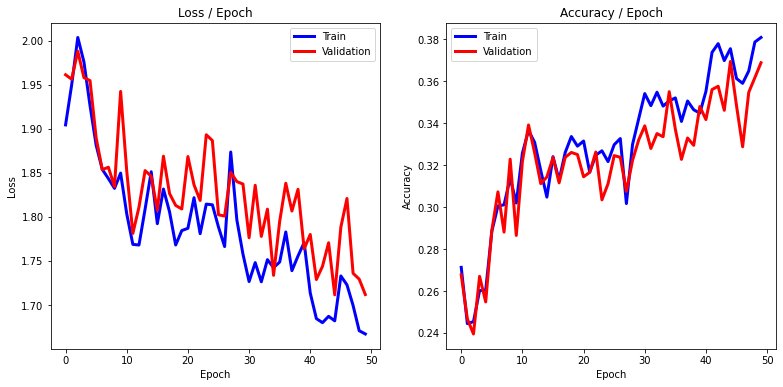

In [65]:
plot_eval(train_acc,test_acc,train_loss,test_loss)

In [66]:
different_models = {
    "vit_depth:2":ViT(depth=2),
    "vit_depth:8":ViT(depth=8),
    "vit_depth:12":ViT(depth=12)
}

In [ ]:
models_results = {}
for model_ in different_models:
  trainable = Trainable(model=different_models[model_],device=device,model_name=model_)
  train_acc , train_loss , test_acc,test_loss = trainable.fit(train_loader,test_loader,epochs=8)
  models_results[model_] = {
      "train_acc":train_acc,
      "train_loss":train_loss,
      "test_acc":test_acc,
      "test_loss":test_loss
  }



Epoch 1 , in time 57.27740931510925 , Train Accuracy: 36.2%, Avg train loss: 1.717675 , Test Accuracy: 34.5%, Avg test loss: 1.788085 

Epoch 2 , in time 115.61855483055115 , Train Accuracy: 36.3%, Avg train loss: 1.713447 , Test Accuracy: 35.5%, Avg test loss: 1.752300 

Epoch 3 , in time 173.4319794178009 , Train Accuracy: 38.2%, Avg train loss: 1.667695 , Test Accuracy: 37.6%, Avg test loss: 1.729188 

Epoch 4 , in time 230.81492733955383 , Train Accuracy: 38.8%, Avg train loss: 1.647281 , Test Accuracy: 38.5%, Avg test loss: 1.674245 

Epoch 5 , in time 289.2316246032715 , Train Accuracy: 37.8%, Avg train loss: 1.666406 , Test Accuracy: 36.6%, Avg test loss: 1.730083 

Epoch 6 , in time 347.0708861351013 , Train Accuracy: 39.4%, Avg train loss: 1.640178 , Test Accuracy: 37.4%, Avg test loss: 1.721866 

Epoch 7 , in time 404.425612449646 , Train Accuracy: 38.1%, Avg train loss: 1.677031 , Test Accuracy: 38.5%, Avg test loss: 1.693219 

Epoch 8 , in time 461.76024889945984 , Train Ac

In [70]:
for x in different_models:
  print(x)

vit_depth:2
vit_depth:8
vit_depth:12
